In [1]:
!pip install ultralytics  -q

Running inference to generate activations and detections...

0: 640x480 1 cat, 7.8ms
Speed: 3.8ms preprocess, 7.8ms inference, 4.3ms postprocess per image at shape (1, 3, 640, 480)
Inference complete.

Displaying the Activation Map with Bounding Boxes:


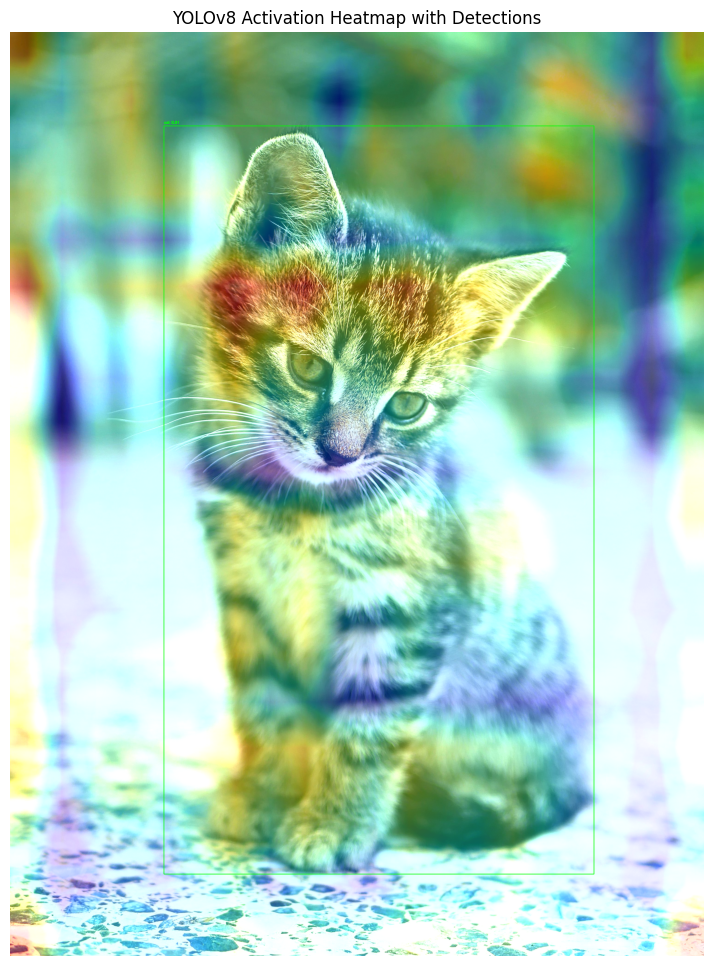

In [10]:
# = a=================================================================
# 1. SETUP: Just install ultralytics and import libraries
# ===================================================================
!pip install ultralytics opencv-python -q

import torch
import cv2
import numpy as np
from PIL import Image
import requests
from ultralytics import YOLO
import matplotlib.pyplot as plt

# ===================================================================
# 2. LOAD YOLOv8 MODEL AND IMAGE
# ===================================================================
# Load a pre-trained YOLOv8 model
model = YOLO('yolov8n.pt')

# Load an image from a URL
image_url = "https://ultralytics.com/images/bus.jpg"
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')


# image_filename = "/content/cat.jpeg"
# image = Image.open(image_filename).convert('RGB')

# Convert image to a numpy array for processing
rgb_img = np.array(image)

# ===================================================================
# 3. HOOK INTO THE MODEL TO CAPTURE ACTIVATIONS
# ===================================================================
feature_maps = []

def hook_fn(module, input, output):
    # The output of the layer is captured here
    feature_maps.append(output)

# Select the target layer.
target_layer = model.model.model[-2]

# Attach the "hook" to the target layer
handle = target_layer.register_forward_hook(hook_fn)

# ===================================================================
# 4. RUN INFERENCE (this will trigger the hook)
# ===================================================================
print("Running inference to generate activations and detections...")

results = model(image)
print("Inference complete.")


handle.remove()

# ===================================================================
# 5. PROCESS AND VISUALIZE THE ACTIVATION MAP WITH BOXES
# ===================================================================
if feature_maps:

    activations = feature_maps[0]

    # Process the heatmap
    heatmap = activations.mean(dim=1).squeeze().cpu().detach().numpy()
    heatmap = (heatmap - np.min(heatmap)) / (np.max(heatmap) - np.min(heatmap))
    resized_heatmap = cv2.resize(heatmap, (image.width, image.height))
    colored_heatmap = plt.cm.jet(resized_heatmap)[:, :, :3]

    # Superimpose the heatmap onto the original image
    superimposed_img = (colored_heatmap * 0.4) + (np.array(image) / 255.0)
    superimposed_img = np.clip(superimposed_img, 0, 1)


    # Convert the superimposed image to a format cv2 can draw on (0-255, BGR)
    final_image = (superimposed_img * 255).astype(np.uint8)
    final_image_bgr = cv2.cvtColor(final_image, cv2.COLOR_RGB2BGR)

    # Loop through all detections in the result
    for box in results[0].boxes:
        # Get coordinates, confidence, and class
        coords = box.xyxy[0].cpu().numpy().astype(int)
        conf = box.conf[0].cpu().numpy()
        class_id = int(box.cls[0].cpu().numpy())
        label = f"{model.names[class_id]} {conf:.2f}"

        # Draw the rectangle
        cv2.rectangle(final_image_bgr, (coords[0], coords[1]), (coords[2], coords[3]), (0, 255, 0), 2)

        # Draw the label text
        cv2.putText(final_image_bgr, label, (coords[0], coords[1] - 10),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)

    # Convert back to RGB for displaying with matplotlib
    final_image_rgb = cv2.cvtColor(final_image_bgr, cv2.COLOR_BGR2RGB)

    # Display the result
    print("\nDisplaying the Activation Map with Bounding Boxes:")
    plt.figure(figsize=(12, 12))
    plt.imshow(final_image_rgb)
    plt.title("YOLOv8 Activation Heatmap with Detections")
    plt.axis('off')
    plt.show()
else:
    print("Could not capture feature maps.")